## Installation instructions

```bash
pip install music21
pip install geopy
pip install folium
pip install pandas
```

After installing music21, run the following

```python
import music21
music21.configure.run()
```

Follow the steps to configure music21

# Milestone 2
## 1. Gathering the data

As mentioned in the previous Milestone, answering our research questions related to the modal organization of Chinese Folk Songs (hereafter CFS) across China requires a dataset of CFS with the following properties:
1. The CFS must come from diverse regions of China
2. The origin of each song must be annotated
3. If possible, the tonic of each song should be annotated

By simply querying these information on a search engine, we found the [Essen Folksong Database](http://www.esac-data.org/). This database contains more than 20'000 scores of folksongs, of which approximately 2250 come from China. This dataset is particularly interesting as it contains the regional information required to answer our research questions. Indeed, not only are the Chinese scores classified into 4 distinct geographical regions (Han, Natmin, Shanxi, Xinhua), which shows diversity in their origins, but each piece also contains a more precise provenance (the province or city). Moreover, each song is annotated with its tonic, though it is unclear whether the annotation is manual or if it has been infered by a software. Therefore, as this dataset fullfils the three criteria above, it is well suited for our project. We can easily download all the relevant data of the Essen Collection from the [KernScore database](https://kern.humdrum.org/cgi-bin/browse?l=essen/asia/china) as a ZIP file. 

It is crucial to note that our dataset can never be exhaustive. Indeed, as we also explained in M1, CFS were an oral tradition and most of the transcriptions were made after the founding of New China in 1949. It is therefore very likely that many songs were forgotten throughout history. However, with almost 2250 CFS, we are confident that grouping them by region will allow us to get a general picture of the folk songs in each area.

## 2. Data format

### 2.1 Kern Format
Originally, the Essen Folksong Database is in a particular format that is inspired by the *Jianpu* notation. While it may have been interesting to work with this format to analyze CFS, for simplicity reasons, we will use a translation of this database in *\*\*kern* format. As a brief summary, the information in *\*\*kern* files is represented as follows:
pitches are represented by letters and durations by numbers.

* Pitch
  * a-g are the absolute pitches above middle C
  * A-G are the absolute pitches below middle C
  * You can double any letter to represent higher or lower pitches
* Duration
  * 1 represents a whole note
  * 2 represents a half note
  * 4 represents a quarter note
  * etc...
* Accidentals
  * \# represents the sharp
  * \- represents the flat

On top of musical data, the *\*\*kern* files can also contain metadata in the format of comments or references. These are followed by a code that denotes what it is about. As instance, the title of the piece is typically indicated in a comment with the code `OTL`.


As a concrete example, here is the *\*\*kern* representation of the following score titled *My Kern Example*:

![lol](example_score.png)
```
!!!OTL: My Kern Example
**kern
{
1B
4g-
8ff
}
```

*\*\*kern* files also allow more complex music representation (e.g. glissando), that we will however mostly not need in this project. [The Humdrum website](https://www.humdrum.org/rep/kern/) provides a complete reference of the music notation in this format.


### 2.2 Examples on a single score
Luckily, we do not need to write our own parser to work with \*\*kern files, as this can be done using the *music21* module, which can be easily installed via *pip*.

In [12]:
from music21 import *
#NOTE TO RAVI AND ZIJUN : This is the MuseCore path on my Computer, you will need to download MuseScore and to specify the path yourself
#Maybe for the final report we indeed only let the .configure thing (although it did not work on my computer)
environment.set('musescoreDirectPNGPath', 'C:\\Program Files\\MuseScore3\\bin\\MuseScore3.exe')

As an example, let's load one song from the regional category *Han* and display it.

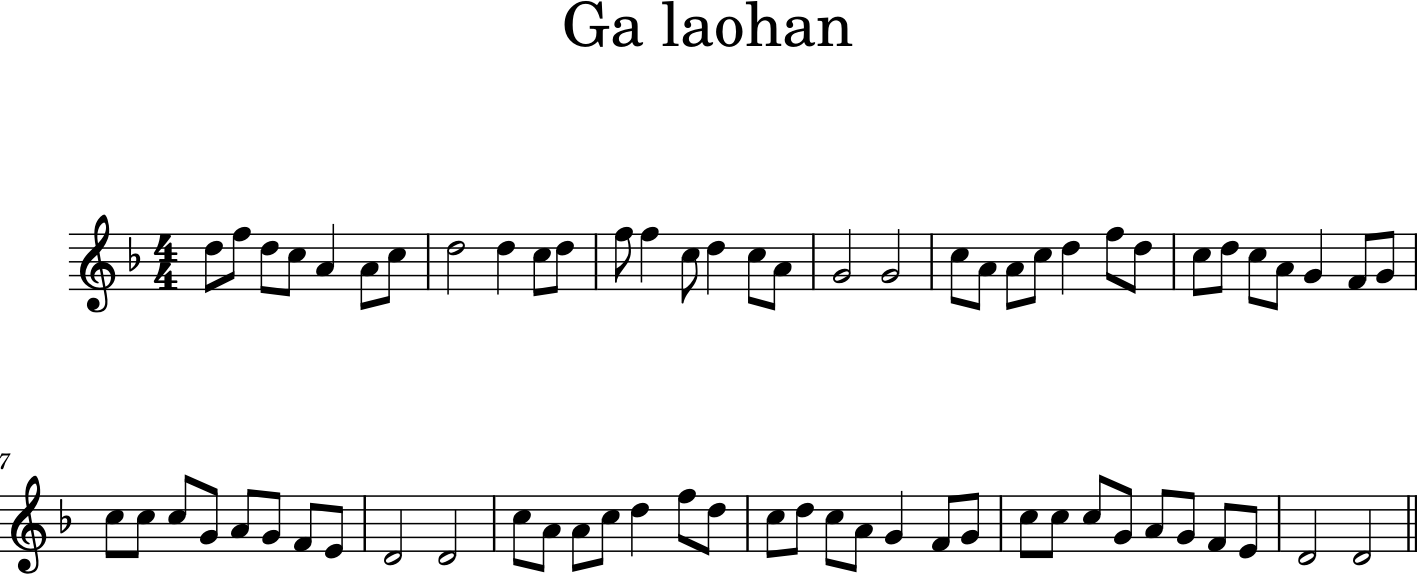

In [13]:
score = converter.parse("data/han/han0111.krn")
score.show()

First, we are interested in the origin of the song. Apart from the regional category (*Han*), the more precise origin of the song is contained in a `GlobalReference` with the code `ARE`. One way to access it is to iterate over all the elements and only print it if it is an element of that type with the correct code.

In [14]:
for element in score:
    if type(element) is humdrum.spineParser.GlobalReference and element.code == "ARE":
        print(element.value)

Asia, China,ÿQinghai, Osten


Second, as our analysis will rely on scale degrees, we will need to access the pitches and their durations as well as the tonic. The following snippet allows us to access all the notes of the first measure and the tonic of the piece.

In [15]:
for part in score.parts:
    for element in part.measure(0):
        if type(element) is key.Key:
            print(f"The tonic is : {element.tonic}")
        if type(element) is note.Note:
            print(element.pitch, element.duration.quarterLength)

The tonic is : F
D5 0.5
F5 0.5
D5 0.5
C5 0.5
A4 1.0
A4 0.5
C5 0.5


It takes only a short visual analysis to notice that it is **extremely** unlikely that F is the tonic of this piece. Indeed, it looks like the tonic is D. Therefore we cannot rely on this annotation and we will have to infer the tonic ourselves (cf. Part 3).

For the sake of this single example, let's assume that its tonic is indeed D. With this information, we can now infer what pentatonic scale is used in this piece. For this purpose, we first need to transpose the piece to C relatively to its tonic (in this case a transposition of -2 since there are 2 semi-tones between C and D). We can easily use *music21*'s `transpose` method to do it

In [16]:
transposed_score = score.transpose(-2)

We can now use *music21*'s `plot` method to get a general pictures of the pitch classes used in this transposed piece.

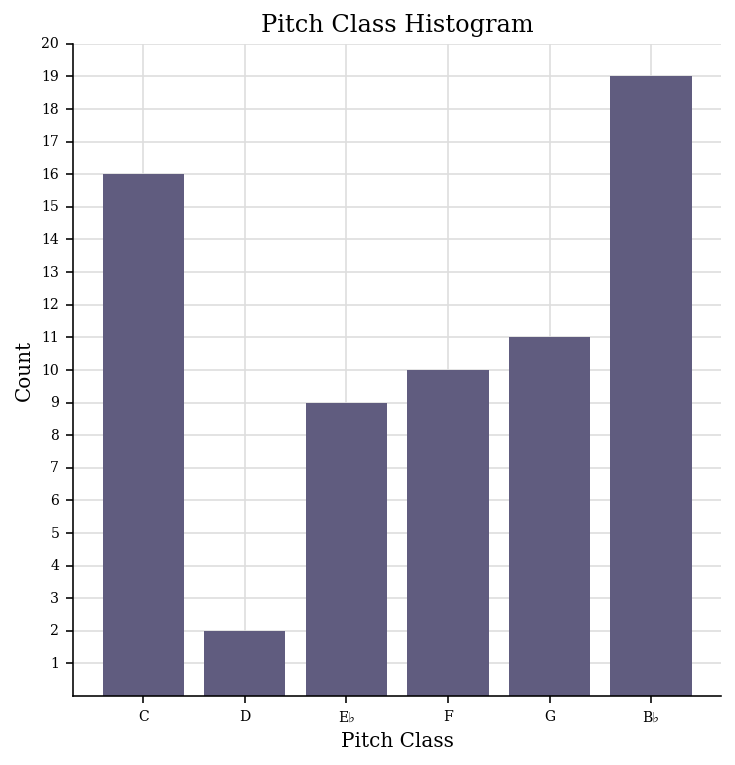

In [17]:
transposed_score.plot('histogram', 'pitchclass')

A quick visual inspection of this plot shows us that the most used pitches are C E<sub>b</sub> F G B<sub>b</sub> which corresponds to the *minor* pentatonic scale

### 2.3 Statistics on the whole dataset

First, we will need to load the whole dataset.

In [18]:
import glob
from tqdm import tqdm

'''
load the scores of each folder into a list
'''
def load_files(path):
    pieces = {"scores": [], "failed_scores": [], "total": 0, "failed": 0}
    for file in tqdm(glob.glob(path+"/*.krn")):
        pieces["total"] += 1
        try:
            pieces["scores"].append(converter.parse(file))
        except:
            pieces["failed"] += 1 
            pieces["failed_scores"].append(converter.parse(file))
    return pieces

In [19]:
music_data = {}

for gloc in ["han", "natmin", "shanxi", "xinhua"]:
    music_data[gloc] = load_files("./data/"+gloc)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 126.92it/s]


In [20]:
# create a dataframe to hold some data that will help in plotting

In [21]:
CFS_stats = []

for gloc in music_data:
    for score in music_data[gloc]["scores"]:
        title = score.metadata.title
        length = len(score.pitches)
        for element in score:
            if type(element) is humdrum.spineParser.GlobalReference and element.code == "ARE":
                location = element.value
        CFS_stats.append([gloc, title, length, location])

In [22]:
import pandas as pd

In [23]:
CFS_df = pd.DataFrame(CFS_stats, columns=["region", "title", "length", "location"])
CFS_df

,region,title,length,location
0,han,Renmin gongshe shizai hao,64,"Asia, China, Shanxi, Zizhou"
1,han,Zanmen de ling xiu Mao Zedong,57,"Asia, China, Shanxi Nordwesten"
2,han,Tian xin shun,24,"Asia, China, Shanxi Yanchang"
3,han,Liu zhi dan,41,"Asia, China, Shanxi Shanbei"
4,han,Zanmen de hongjun shi li zhong,24,"Asia, China, Shanxi Shanbei"
...,...,...,...,...
2236,xinhua,Moli hua,174,"Asia, China, Jiangsu"
2237,xinhua,Yitang qingshui yitang lian,90,"Hunan, Hengshan"
2238,xinhua,Ta4i ya2ng chu1 la2i xi3 ya2ng ya2ng Auf geht ...,30,"Asia, Ostasien, China, Sichuan"
2239,xinhua,Moli hua,174,"Asia, China, Jiangsu"


# Start Geographical Locations

In [44]:
from geopy.geocoders import Nominatim
import re
cache = dict()
def name_to_location(name):
    geolocator = Nominatim(user_agent="DH-401 CFS")
    names = name.strip(" ").replace(", ", ",").replace(" ", ",").split(",")
    for i in range(len(names)):
        if names[len(names)-1-i] in cache.keys():
            return cache[names[len(names)-1-i]]
        location = geolocator.geocode(names[len(names)-1-i])
        if location is not None:
            cache[names[len(names)-1-i]] = location
            return location
    return None

In [45]:
#Takes an eternity to run
CFS_df["true_location"] = CFS_df.location.apply(name_to_location)

In [64]:
import folium
map_ = folium.Map()
locations = list()
for _, row in CFS_df.iterrows():
    if row["true_location"] is None:
        continue
    if row["true_location"].latitude + row["true_location"].longitude in locations:
        continue
    if row["region"] == "han":
        color = "blue"
    elif row["region"] == "shanxi":
        color="red"
    elif row["region"] == "natmin":
        color="black"
    else:
        color = "green"
    folium.Marker([row["true_location"].latitude, row["true_location"].longitude], popup=row["location"], icon=folium.Icon(color=color)).add_to(map_)
    locations.append(row["true_location"].latitude + row["true_location"].longitude)

In [65]:
map_

# End Geographical Locations

In [90]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

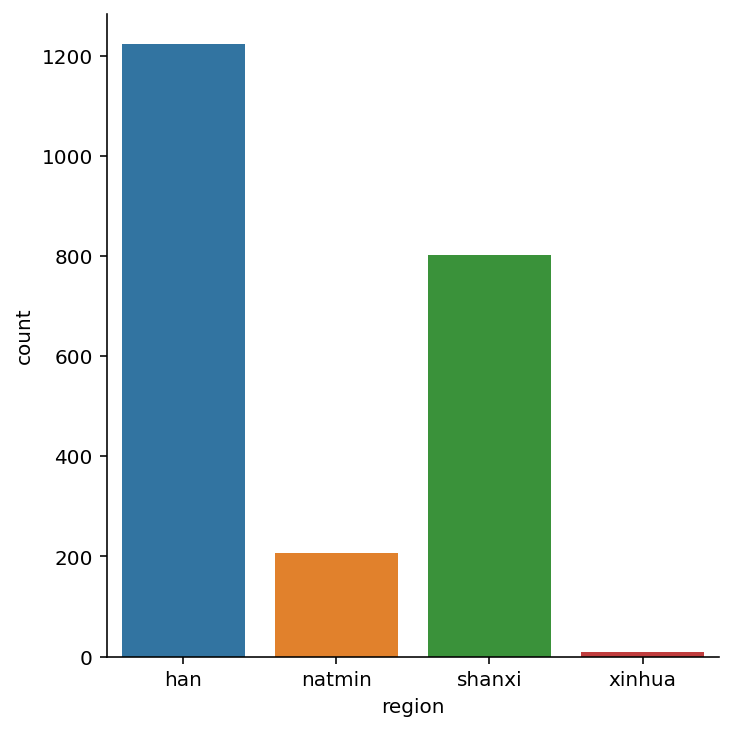

In [30]:
sns.catplot(x="region", kind="count", data=CFS_df)

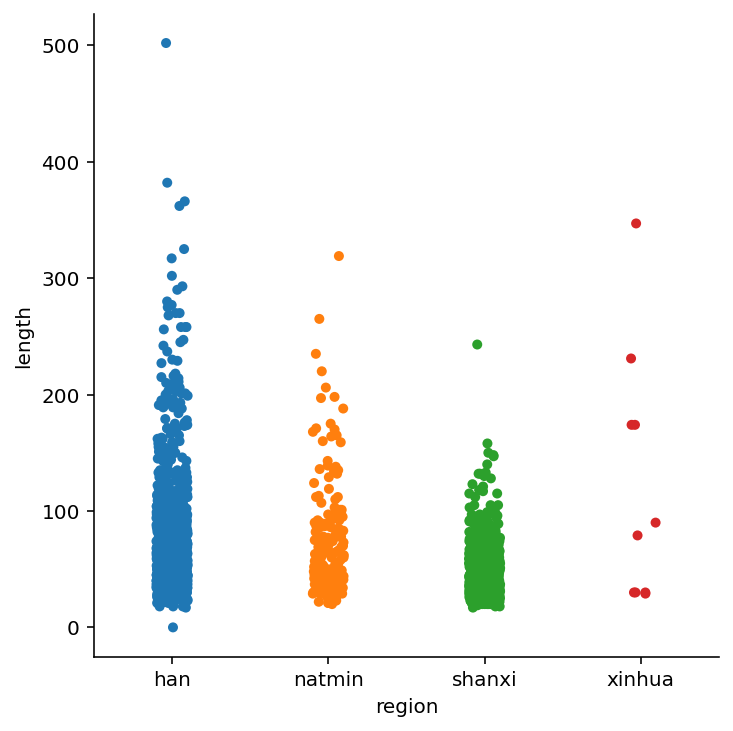

In [31]:
sns.catplot(x="region", y="length", data=CFS_df)

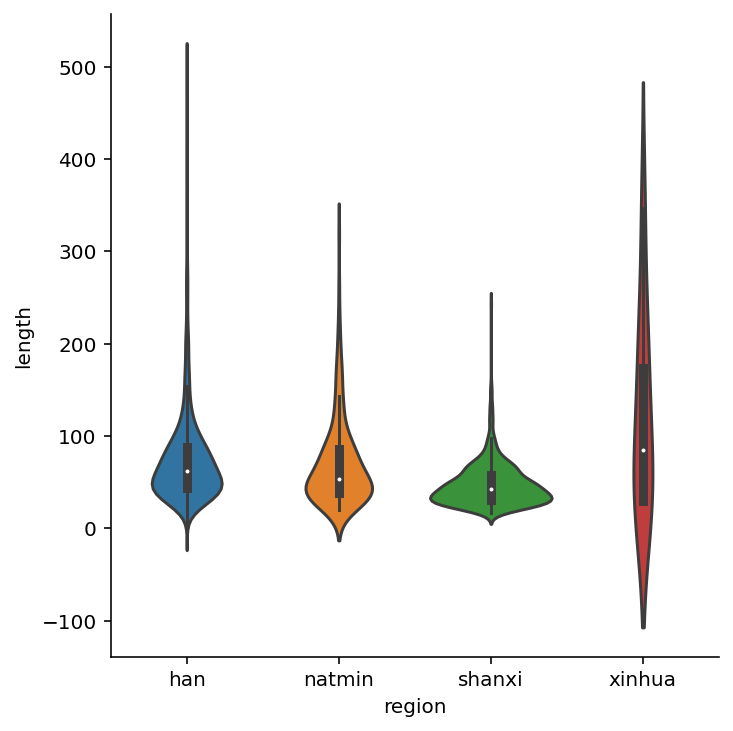

In [32]:
sns.catplot(x="region", y="length", data=CFS_df, kind="violin")

### Pitch statistics

This could be part 3 in the M2.

In [33]:
region_pitch_stat = {}

for gloc in music_data:
    if gloc not in region_pitch_stat:
        region_pitch_stat[gloc] = []
    for score in music_data[gloc]["scores"]:
        pitches = [str(pitch) for pitch in score.pitches]
        region_pitch_stat[gloc].extend(pitches)

In [34]:
from collections import Counter

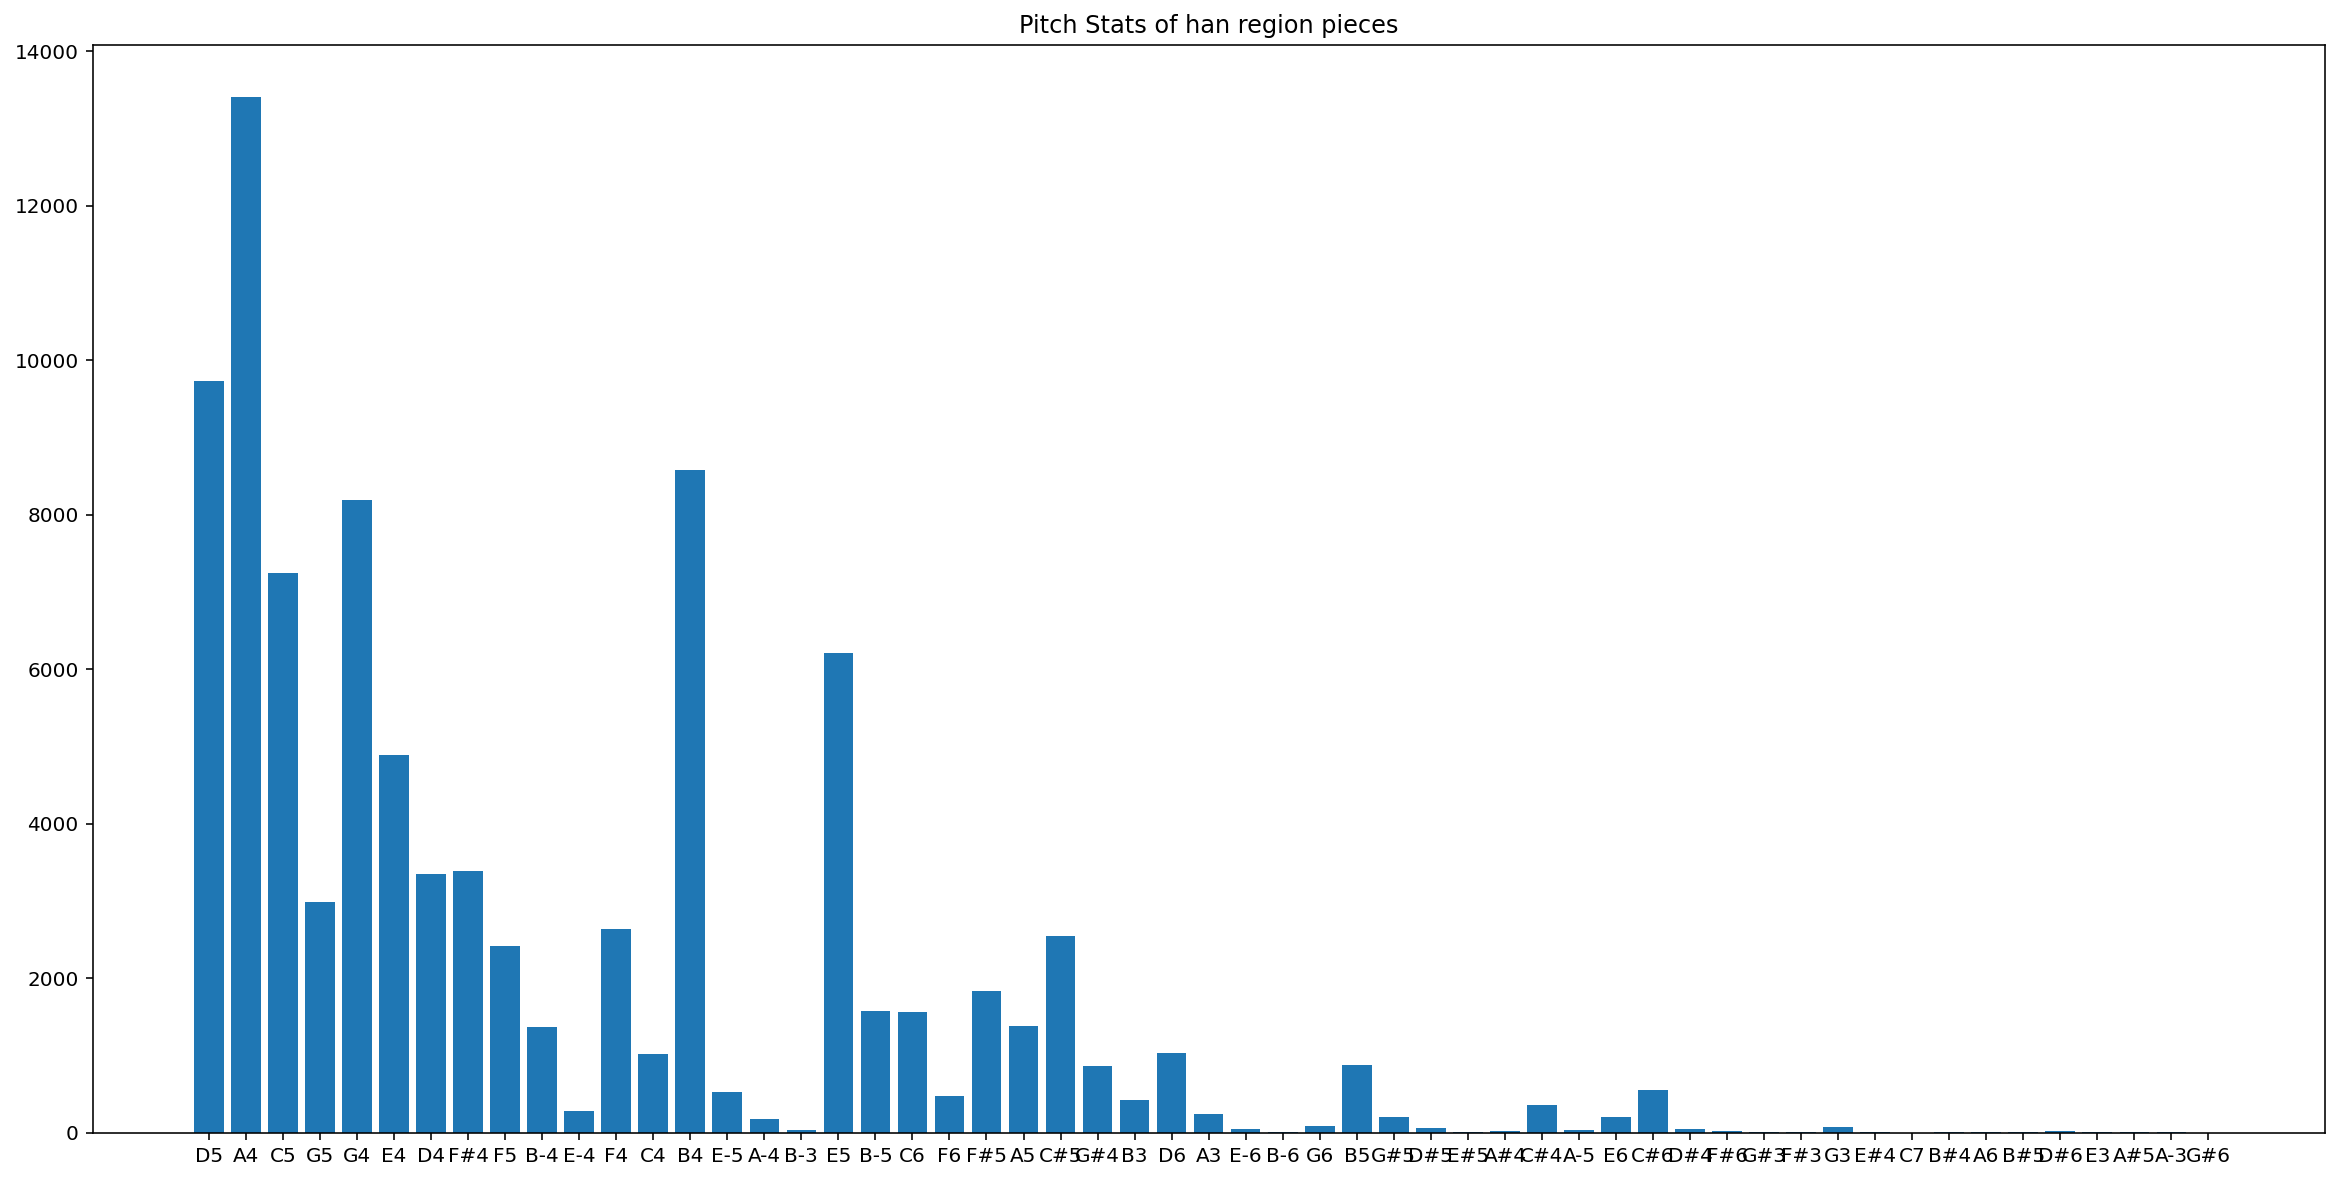

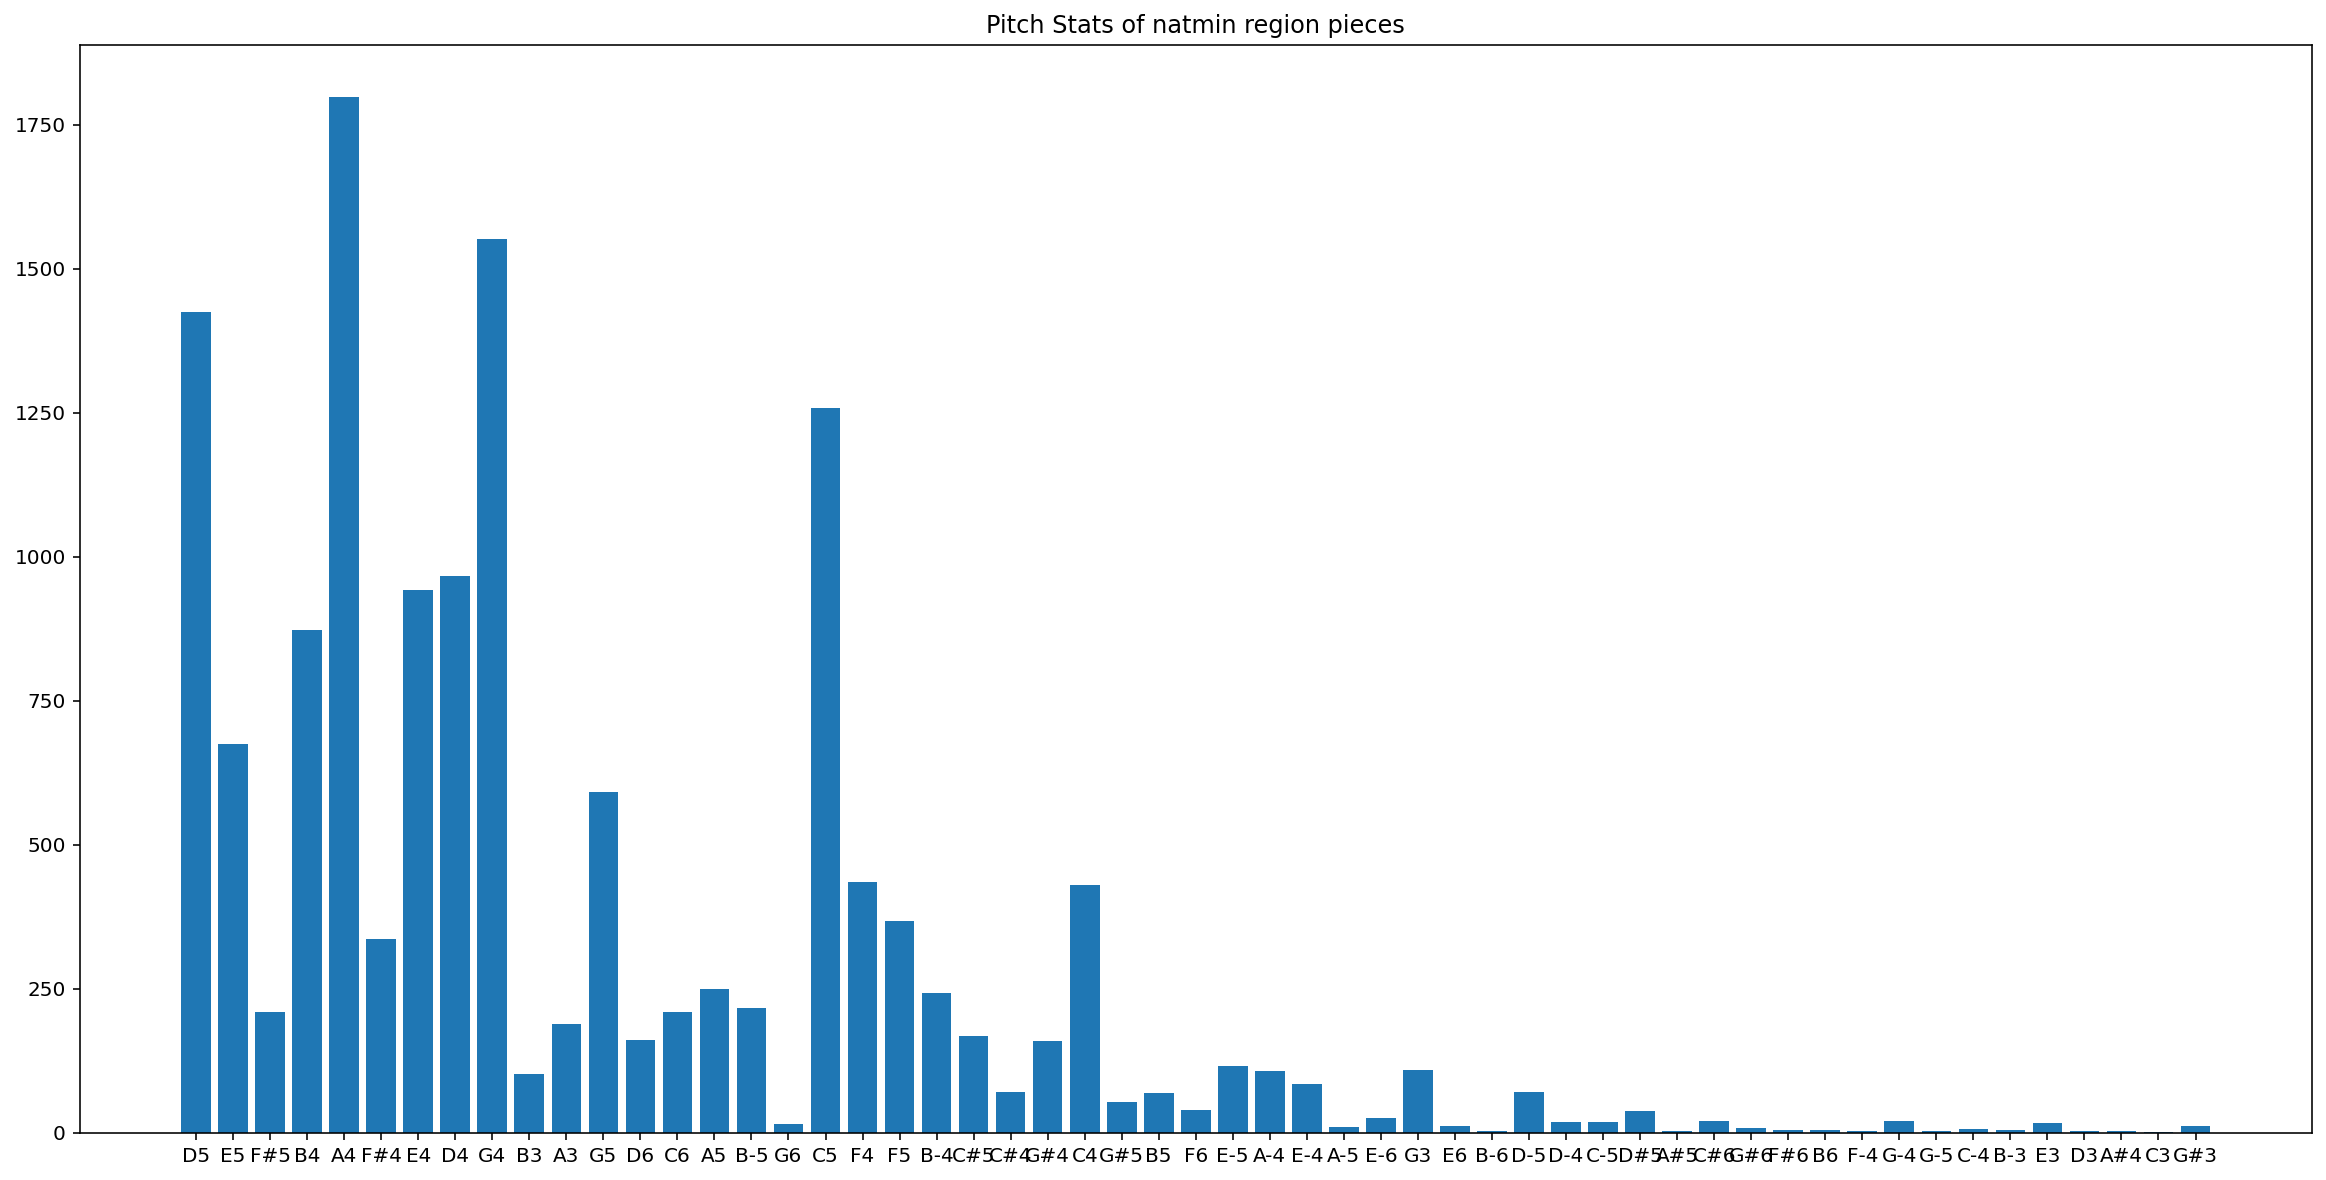

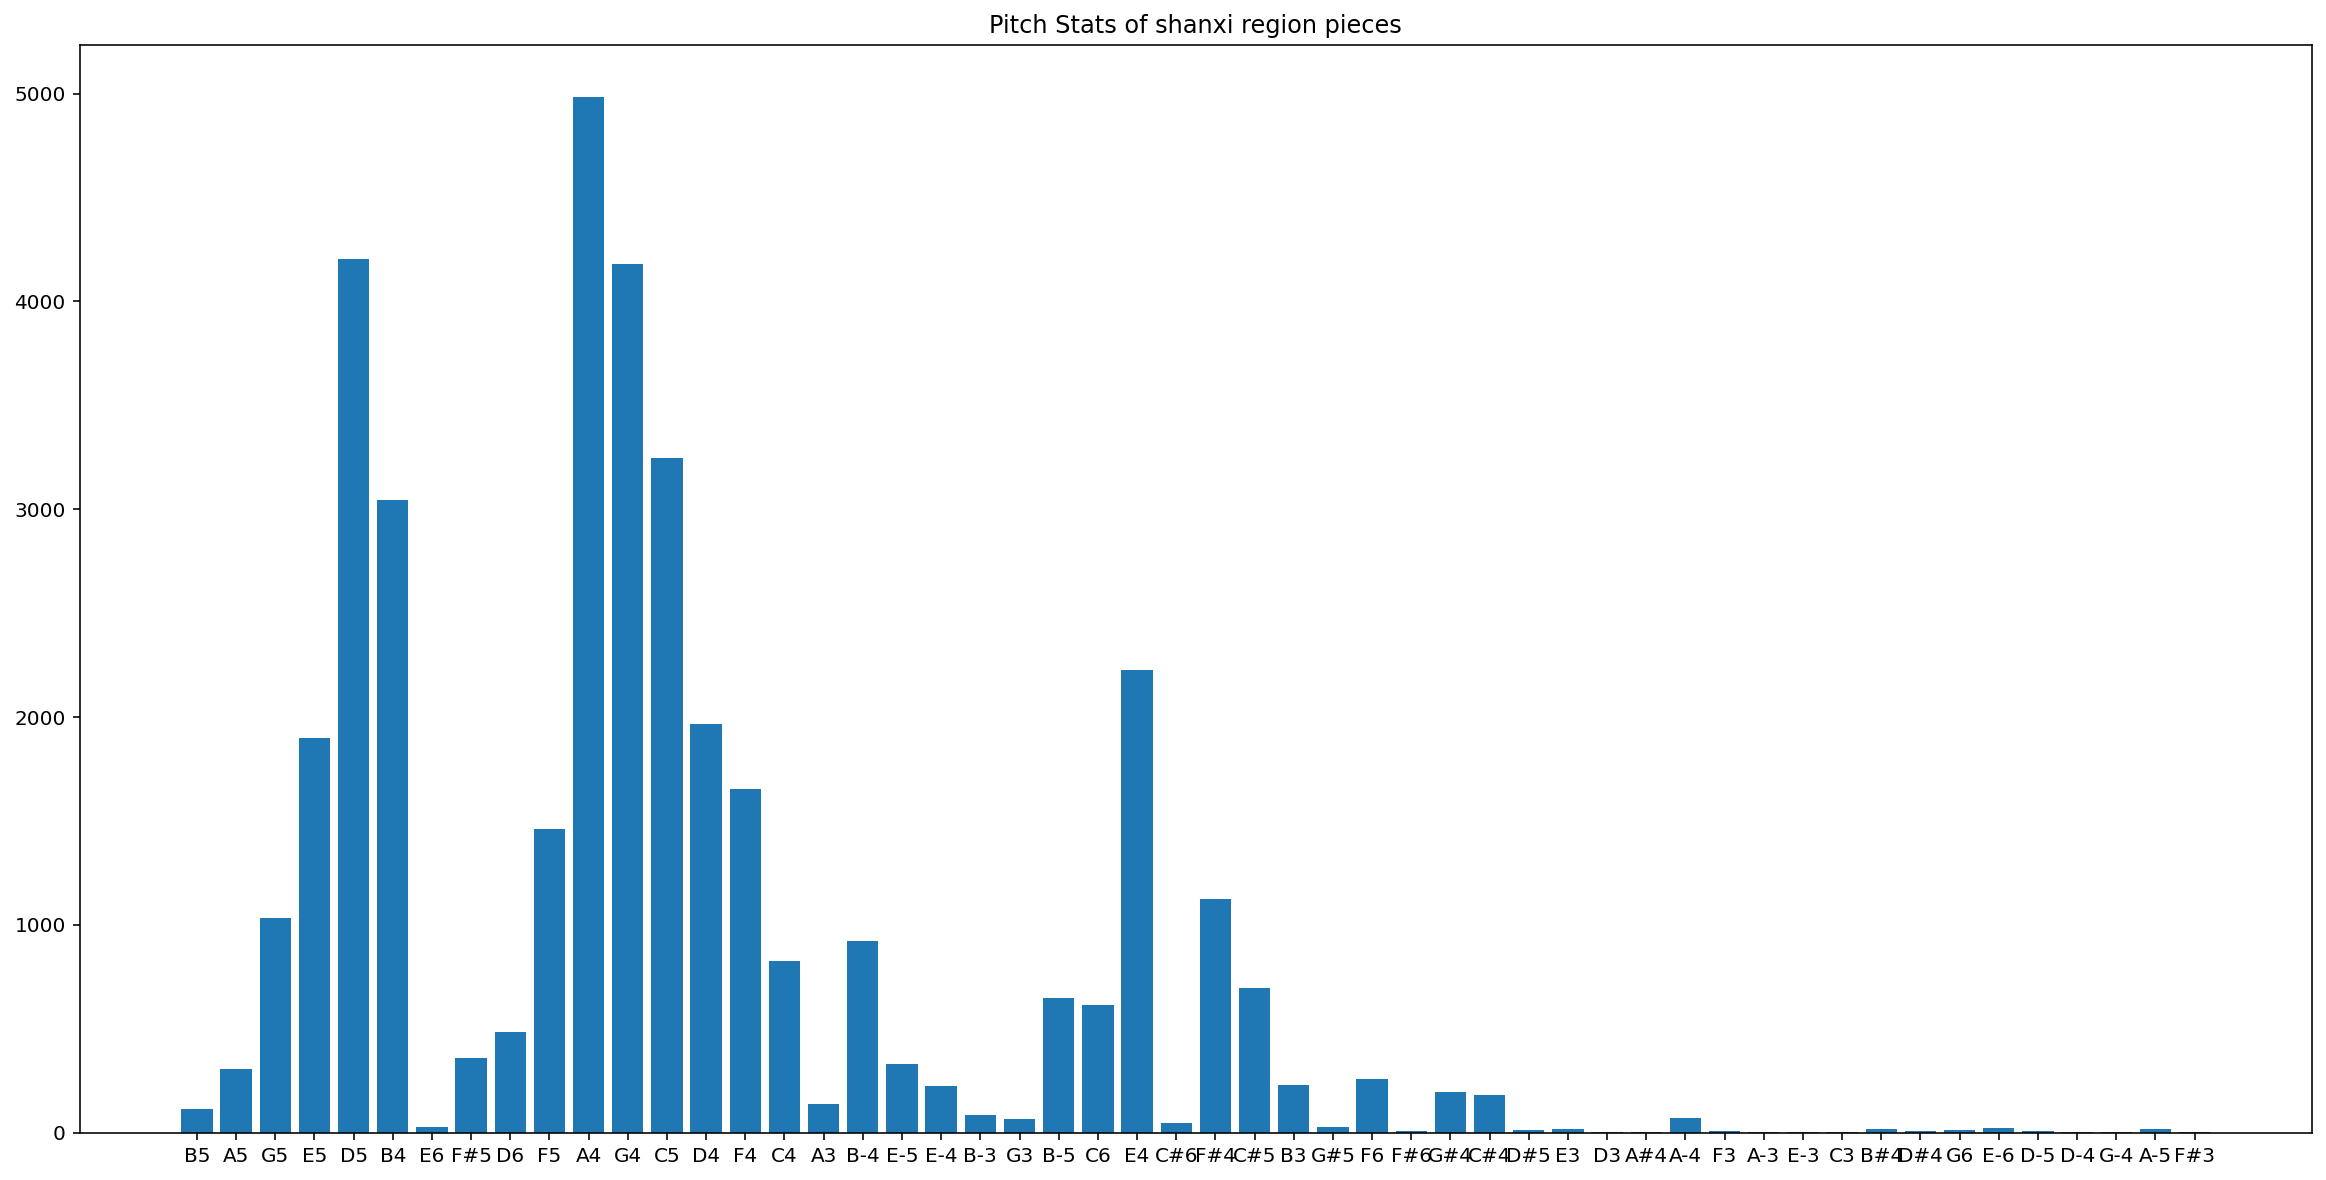

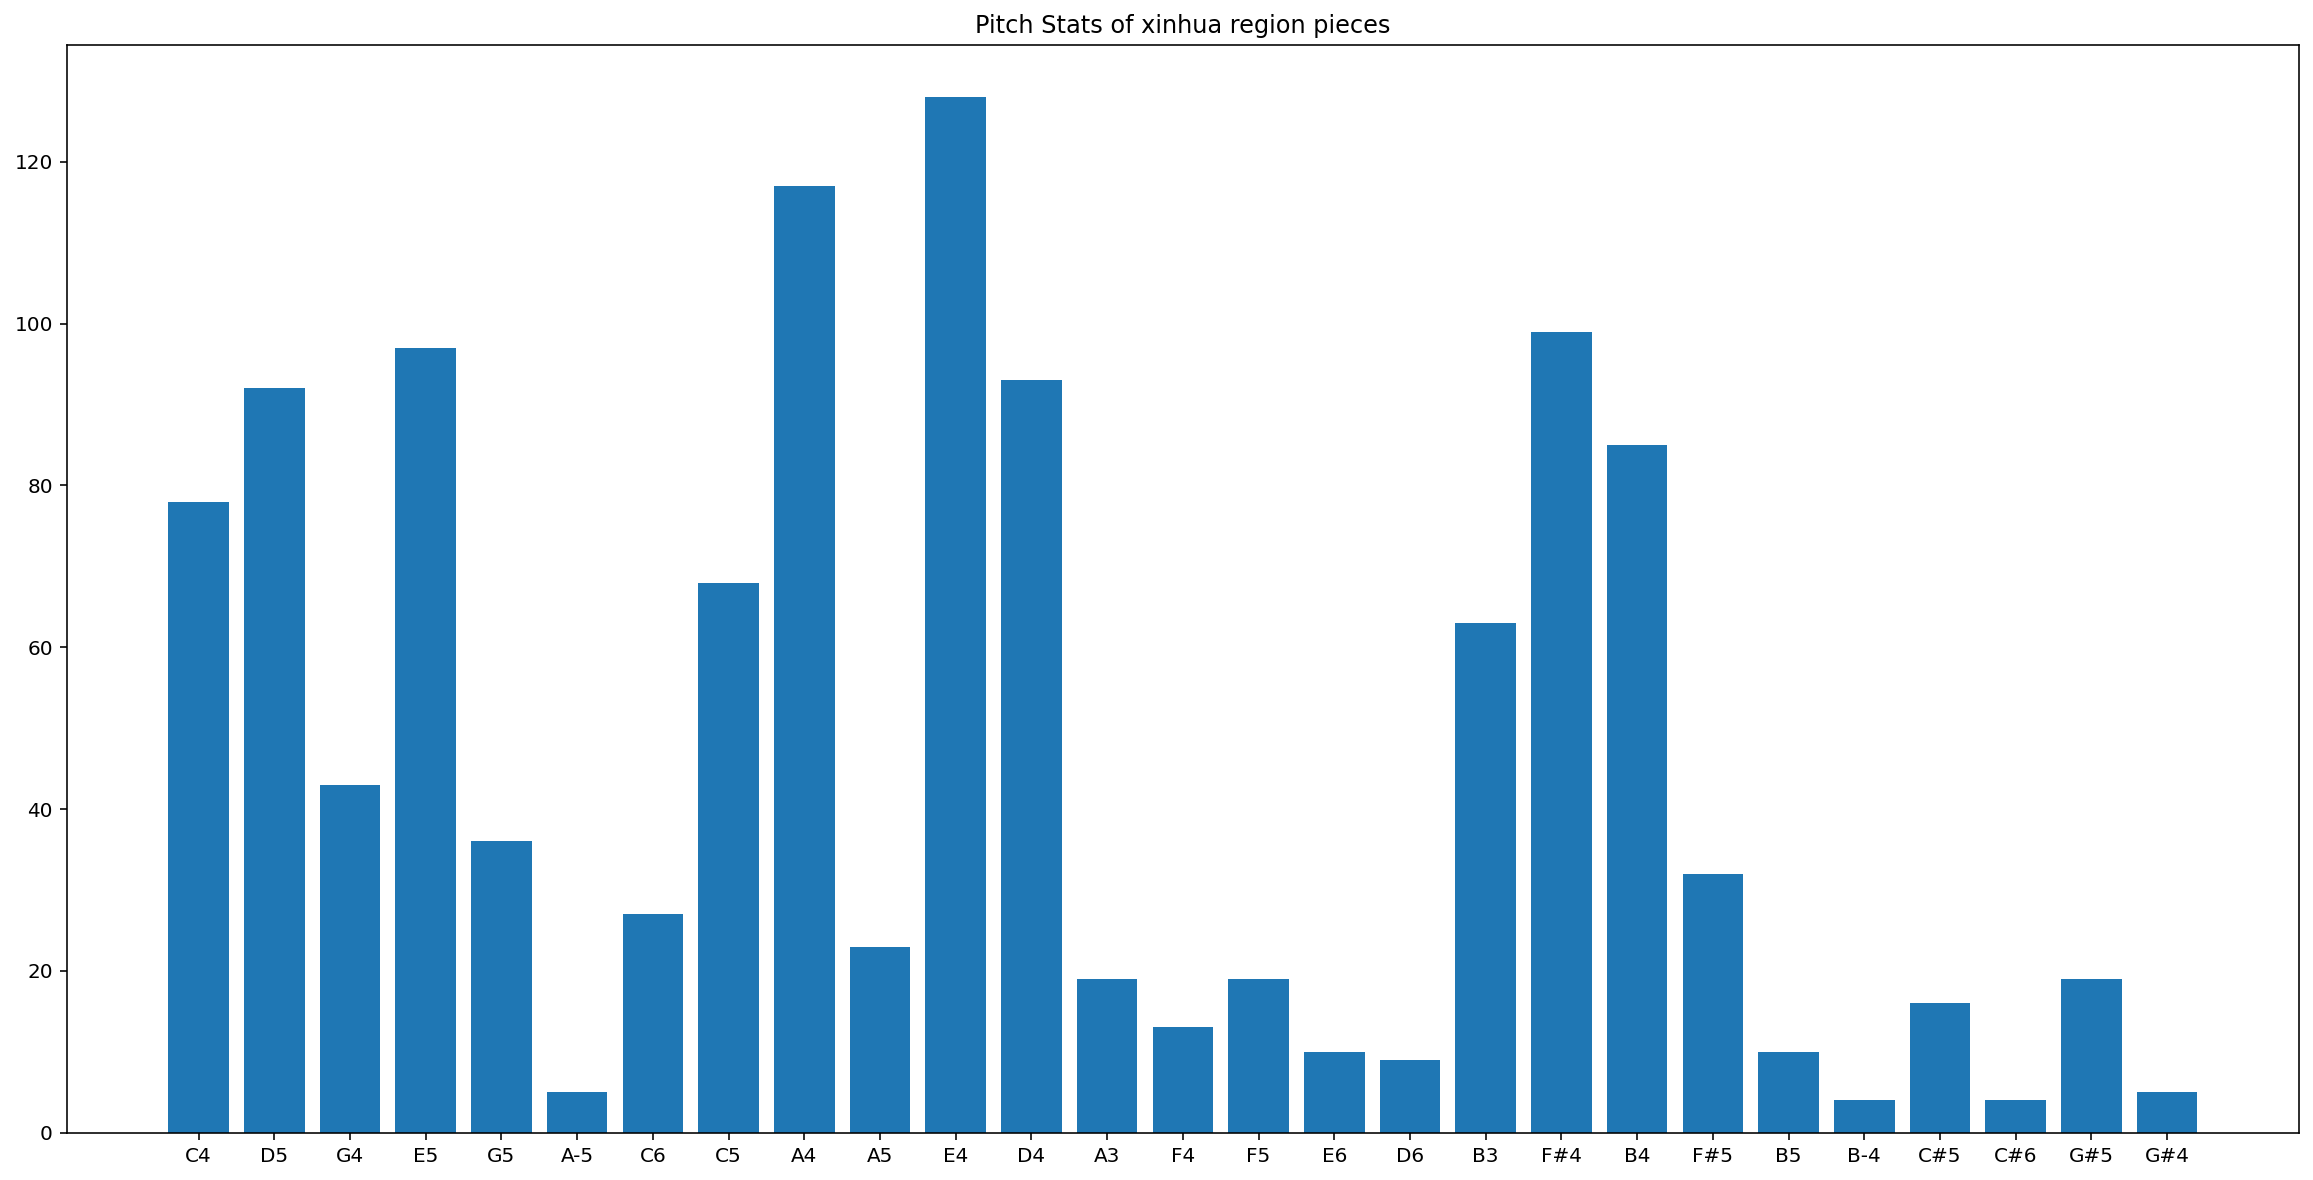

In [35]:
region_pitch_counts = {}
for gloc in region_pitch_stat:
    region_pitch_counts[gloc] = Counter(region_pitch_stat[gloc])
    plt.bar(region_pitch_counts[gloc].keys(), region_pitch_counts[gloc].values())
    plt.title("Pitch Stats of {} region pieces".format(gloc))
    plt.show()